##IMPORTS

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

##CSV TRATAMENTS

In [ ]:
#LEITURA
dataFrame = pd.read_csv("ovni.csv", error_bad_lines=False) #Le o dataFrame

#TRATAMENTOS
dataFrame["datetime"] = pd.to_datetime(dataFrame["datetime"], errors='coerce') #Converte para data a coluna DateTime
dataFrame["year"] = dataFrame["datetime"].dt.strftime('%Y') #Depois de convertido, conseguimos pegar o ano
dataFrame.loc[:,'appearances'] = 1 #Adiciona no dataFrame a coluna de contagem de aparições
dataFrame = dataFrame.reindex(columns=['year', 'appearances']) #Reindex da coluna dos anos e valores 
                                                               #e mantem somendo os 2 campos selecionas
#SOMA DE APARIÇÕES
dataFrame = dataFrame.groupby(["year"])['appearances'].sum().reset_index() #Agrupa os valores por ano
dataFrame = dataFrame.set_index("year") #define o ano como index

dataFrame

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 878: expected 11 fields, saw 12\nSkipping line 1713: expected 11 fields, saw 12\nSkipping line 1815: expected 11 fields, saw 12\nSkipping line 2858: expected 11 fields, saw 12\nSkipping line 3734: expected 11 fields, saw 12\nSkipping line 4756: expected 11 fields, saw 12\nSkipping line 5389: expected 11 fields, saw 12\nSkipping line 5423: expected 11 fields, saw 12\nSkipping line 5614: expected 11 fields, saw 12\nSkipping line 5849: expected 11 fields, saw 12\nSkipping line 6093: expected 11 fields, saw 12\nSkipping line 7516: expected 11 fields, saw 12\nSkipping line 7626: expected 11 fields, saw 12\nSkipping line 8893: expected 11 fields, saw 12\nSkipping line 9015: expected 11 fields, saw 12\nSkipping line 9571: expected 11 fields, sa

,appearances
year,
1906,1
1910,2
1914,1
1916,1
1920,1
...,...
2010,4654
2011,5478
2012,7857


##VISUAL CHARTS

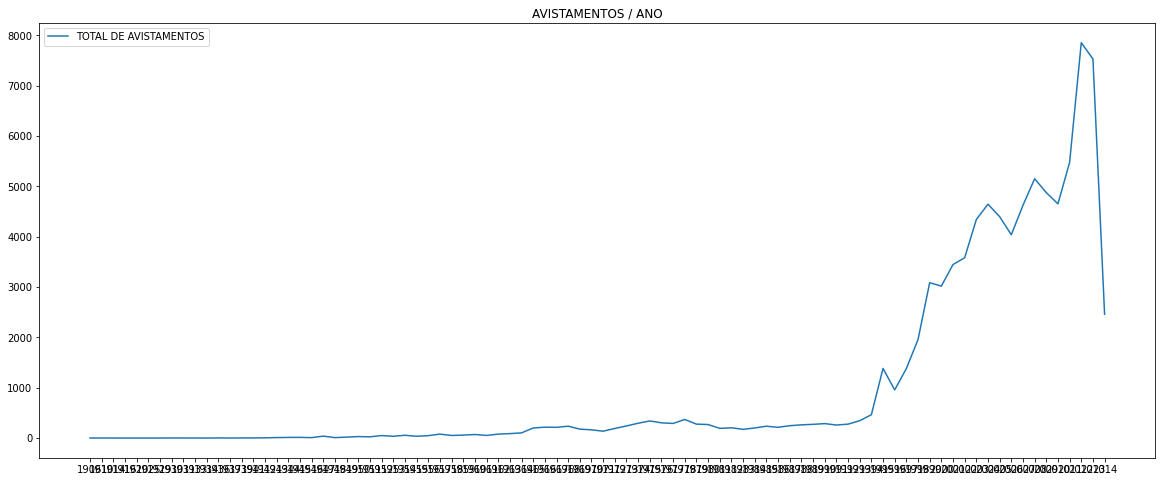

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='TOTAL DE AVISTAMENTOS');
ax.legend();
ax.set_title("AVISTAMENTOS / ANO");

##DESCRIPTION

In [ ]:
dataFrame.describe()

,appearances
count,88.000000
mean,993.852273
std,1829.670252
min,1.000000
25%,23.500000
50%,197.000000
75%,351.250000
max,7857.000000


##OUTLIERS

In [ ]:
q1 = dataFrame["appearances"].quantile(0.25)
q3 = dataFrame["appearances"].quantile(0.75)
iqr = q3-q1 
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
dataFrame = dataFrame.loc[(dataFrame["appearances"] > fence_low) & (dataFrame["appearances"] < fence_high)]

In [ ]:
dataFrame.describe()

,appearances
count,68.000000
mean,126.000000
std,123.538018
min,1.000000
25%,9.000000
50%,74.500000
75%,236.000000
max,464.000000


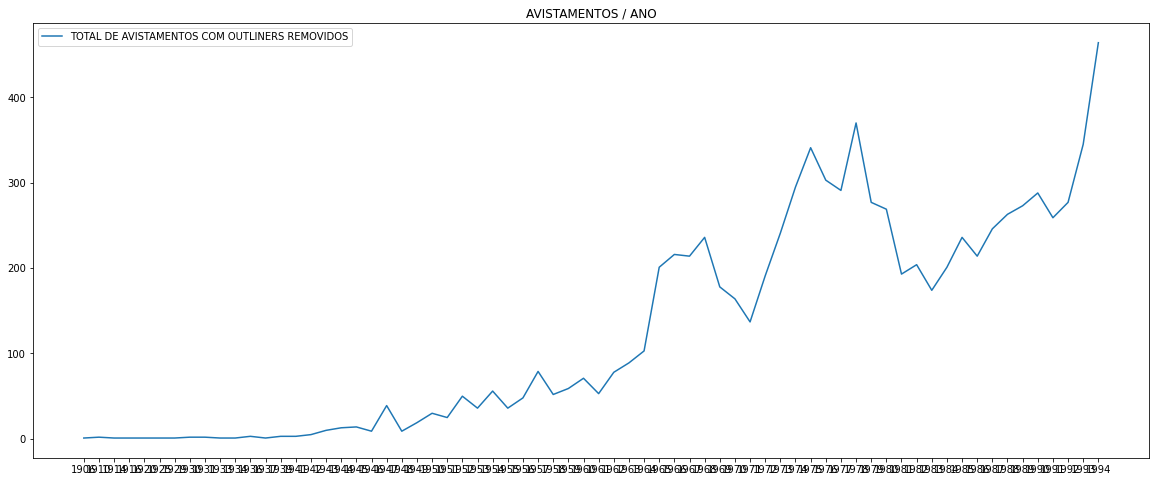

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='TOTAL DE AVISTAMENTOS COM OUTLINERS REMOVIDOS');
ax.legend();
ax.set_title("AVISTAMENTOS / ANO");

##NORMALIZE TESTS


In [ ]:
#KSTEST
stats.kstest(dataFrame['appearances'],'norm')

statistic, pvalue = stats.kstest(dataFrame['appearances'],'norm')

if pvalue > 0.29407:
  print("KSTEST - Distribuição Normal")
else: 
  print("KSTEST - Não é uma distribuição Normal")


KSTEST - Não é uma distribuição Normal


In [ ]:
#SHAPIRO
if stats.shapiro(dataFrame['appearances'])[1] > 0.05:
    print("Distribuição Normal")
else:
    print("Não é uma distribuição Normal")

Não é uma distribuição Normal


In [ ]:
#BOXCOX
dataFrameNormalized = dataFrame
dataFrameNormalized['appearances'], lambda_boxcox = stats.boxcox(dataFrame['appearances'])
dataFrameNormalized

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,appearances
year,
1906,0.000000
1910,0.759602
1914,0.000000
1916,0.000000
1920,0.000000
...,...
1990,12.932780
1991,12.475770
1992,12.763622


In [ ]:
#KSTEST
stats.kstest(dataFrame['appearances'],'norm')

statistic, pvalue = stats.kstest(dataFrame['appearances'],'norm')

if pvalue > 0.29407:
  print("KSTEST - Distribuição Normal")
else: 
  print("KSTEST - Não é uma distribuição Normal")


KSTEST - Não é uma distribuição Normal


In [ ]:
#SHAPIRO
if stats.shapiro(dataFrame['appearances'])[1] > 0.05:
    print("Distribuição Normal")
else:
    print("Não é uma distribuição Normal")

Não é uma distribuição Normal


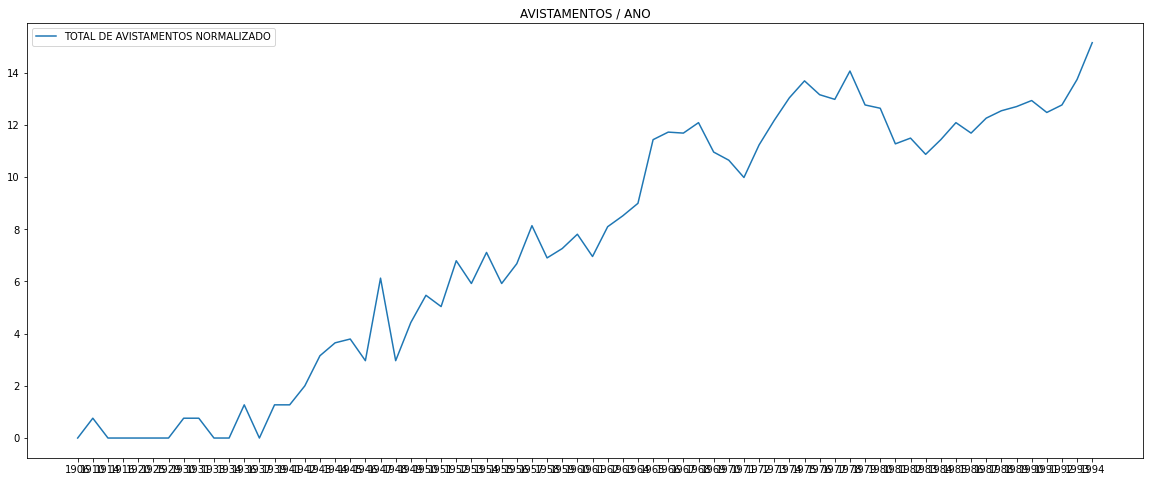

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame.values, label='TOTAL DE AVISTAMENTOS NORMALIZADO');
ax.legend();
ax.set_title("AVISTAMENTOS / ANO");

##ARIMA

In [ ]:
rowCount = len(dataFrame.index)
size = round(rowCount*0.2)
size

14

In [ ]:
dataFrameArima = dataFrameNormalized

X = dataFrameArima.values
size = int(len(X) * 0.8)
dataFrameAnimaPrev = dataFrameArima[size:]
dataFrameAnimaPrev['quantity'] = dataFrameAnimaPrev['appearances']
training, test = X[0:size],X[size:]
history = [x for x in training]
for i in range(len(test+2)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    observation = test[i]
    history.append(observation)
    dataFrameAnimaPrev['quantity'][-len(test)+i-1:-len(test)+i] = yhat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._set_values(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.lau

In [ ]:
error = math.sqrt(mean_squared_error(test, dataFrameAnimaPrev['quantity'].values))
print('Erro médio quadratico: ', error)

Erro médio quadratico:  0.23523142007235762


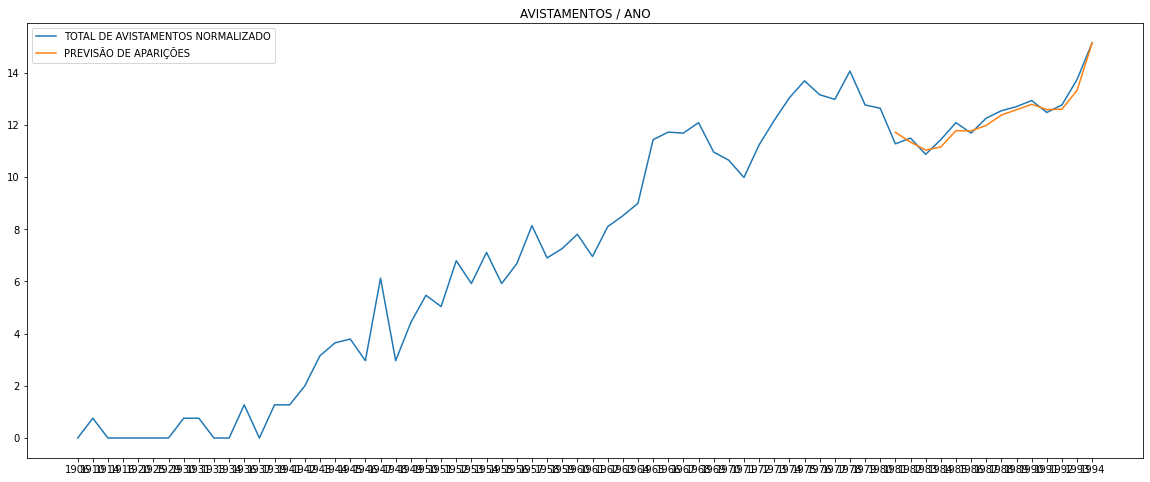

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dataFrame.index, dataFrame['appearances'].values, label='TOTAL DE AVISTAMENTOS NORMALIZADO');
ax.plot(dataFrameAnimaPrev.index, dataFrameAnimaPrev['quantity'].values, label='PREVISÃO DE APARIÇÕES');
ax.legend();
ax.set_title("AVISTAMENTOS / ANO");